In [1]:
# Import necessary packages

import numpy as np
import scipy as sp
import skimage as sk

import matplotlib.pyplot as plt

import matplotlib.path as Path
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import minimum_filter, median_filter

import os

import importlib

from PIL import Image

from colour import Color

%matplotlib notebook

C:\Users\lopab\AppData\Local\Temp\ipykernel_35760\1133591826.py:12: DeprecationWarning: Please use `minimum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import minimum_filter, median_filter
C:\Users\lopab\AppData\Local\Temp\ipykernel_35760\1133591826.py:12: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import minimum_filter, median_filter


In [2]:
from tifffile import imread
from scipy.ndimage import gaussian_filter


import sys
sys.path.append("C:/Users/lopab/Box/Cornell Research/codes/GitHub/kemstem/src/")
import kemstem

importlib.reload(kemstem)

<module 'kemstem' from 'C:\\Users/lopab/Box/Cornell Research/codes/GitHub/kemstem/src\\kemstem\\__init__.py'>

In [3]:
kemstem.extensions.ruddlesden_popper

<module 'kemstem.extensions.ruddlesden_popper' from 'C:\\Users/lopab/Box/Cornell Research/codes/GitHub/kemstem/src\\kemstem\\extensions\\ruddlesden_popper.py'>

# Loading image
First we'll need to load our STEM image. Registered images work best, but most images with atomic resolution should work.

Image shape (1024, 1024)
Cropped to (1024, 1024)
Normalized to min: 0.0, max: 1.0


<IPython.core.display.Javascript object>


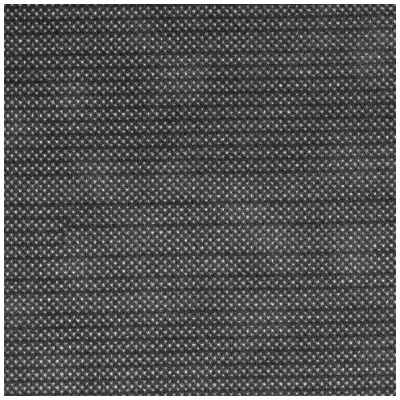

(-0.5, 1023.5, 1023.5, -0.5)

In [4]:
filename = 'C:\\Users\\lopab\\Box\\Cornell Research\\codes\\Erin_RP_code\\27_SRO_5-1Mx_12us_1024px.tif'

image = imread(filename)
print(f'Image shape {image.shape}')
image = image[:min(image.shape),:min(image.shape)]
print(f'Cropped to {image.shape}')
image = kemstem.util.normalize(image)
print(f'Normalized to min: {image.min()}, max: {image.max()}')

fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(4,4))
ax.matshow(image,cmap='gray')
ax.axis('off')

<IPython.core.display.Javascript object>


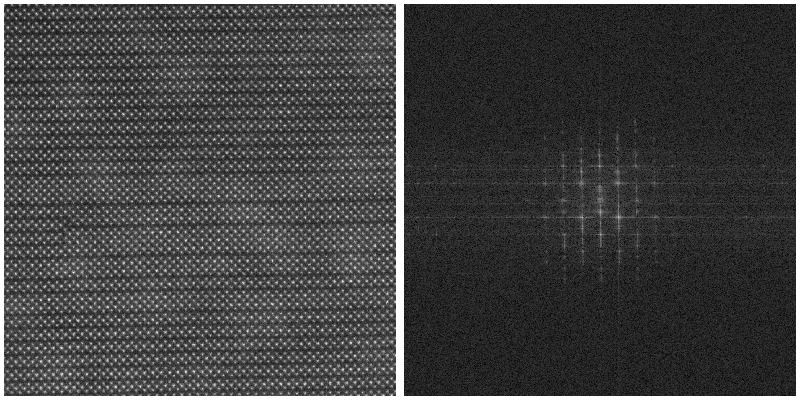

(-0.5, 1023.5, 1023.5, -0.5)

In [5]:
pattern_c = kemstem.fourier.prepare_fourier_pattern(image)
pattern_log = kemstem.fourier.prepare_fourier_pattern(image,log=True,log_offset=1e1) # Here we also take a log transform of the FFT for ease of visualization

fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(8,4))
ax[0].matshow(image,cmap='gray')
ax[0].axis('off')
ax[1].matshow(pattern_log,cmap='gray')
ax[1].axis('off')

<IPython.core.display.Javascript object>


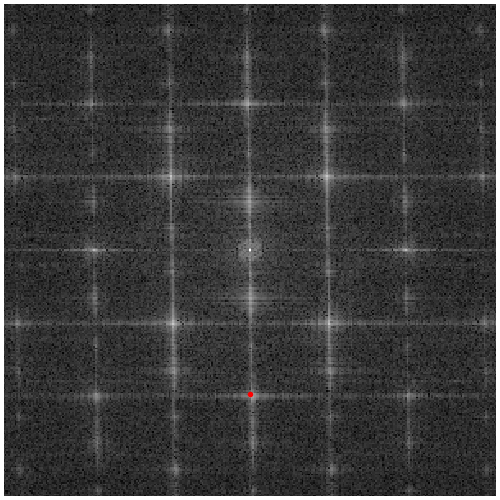

In [6]:
selected_peaks = kemstem.fourier.select_peaks(pattern_log,zoom=150,select_conjugates=False,figsize=(5,5),delete_within=5)

In [7]:
# uncomment and run to use preselected peak(s)
#selected_peaks = np.array([[601.2128707453212, 513.2256758235744]])

Selected X positions: [511.98093218]
Selected Y positions: [599.77872072]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.85it/s]


<IPython.core.display.Javascript object>


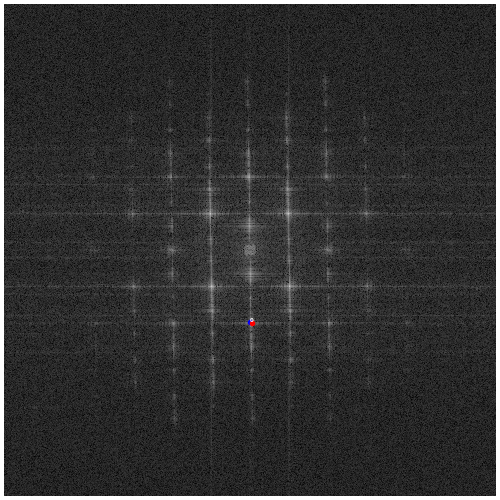

<IPython.core.display.Javascript object>


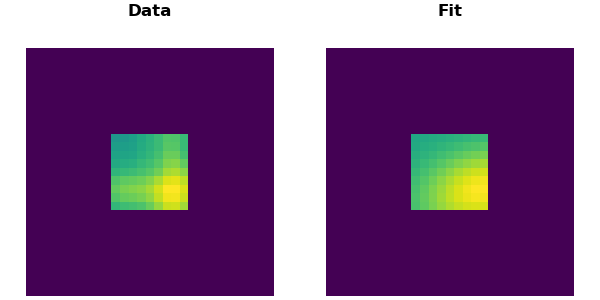

In [8]:
p0 = np.array(selected_peaks).T
print(f'Selected X positions: {p0[:,1]}')
print(f'Selected Y positions: {p0[:,0]}')

peaks_ref,errs,opts,data_fits  = kemstem.fourier.refine_peaks_gf(gaussian_filter(pattern_log,1), p0, window_dimension=9,store_fits=True, remove_unfit = False)
fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(5,5))
kemstem.util.plot_numbered_points(pattern_log,p0,ax=ax,color='b',zoom=300)
ax.plot(peaks_ref[:,1],peaks_ref[:,0],'r.')
ax.axis('off')

_ = kemstem.util.plot_fit_comparison(data_fits,)

In [9]:
peaks_ref = np.array([[601.2128707453212, 513.2256758235744]])

<IPython.core.display.Javascript object>


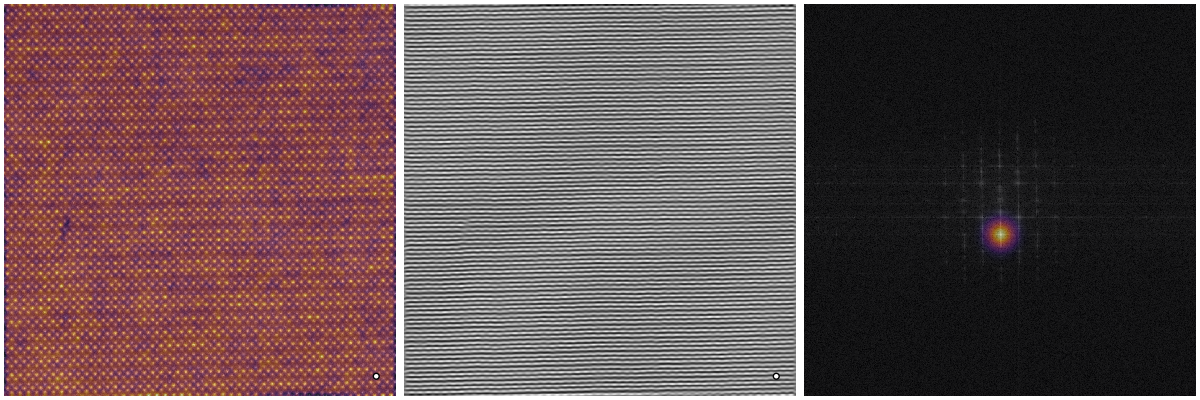

In [10]:
peak_index = 0
sigma= 25
filtered_im, filtered_ft, mask = kemstem.fourier.fourier_filter(pattern_c,peaks_ref[peak_index,:],sigma=sigma)

fig,ax = plt.subplots(1,3,constrained_layout=True,figsize=(12,4))
ax[0].matshow(image,cmap='gray')
ax[0].matshow(np.abs(filtered_im),cmap='inferno',alpha=.5)
ax[0].axis('off')
ax[1].matshow(np.real(filtered_im),cmap='gray')
ax[1].axis('off')
ax[2].matshow(pattern_log,cmap='gray')
ax[2].matshow(mask,alpha=.5,cmap='inferno')
ax[2].axis('off')

kemstem.util.coarsening_marker(ax[0],kemstem.fourier.coarsening_length(image.shape[0],sigma),edgecolor='k',facecolor='w')
kemstem.util.coarsening_marker(ax[1],kemstem.fourier.coarsening_length(image.shape[0],sigma),edgecolor='k',facecolor='w')

<IPython.core.display.Javascript object>


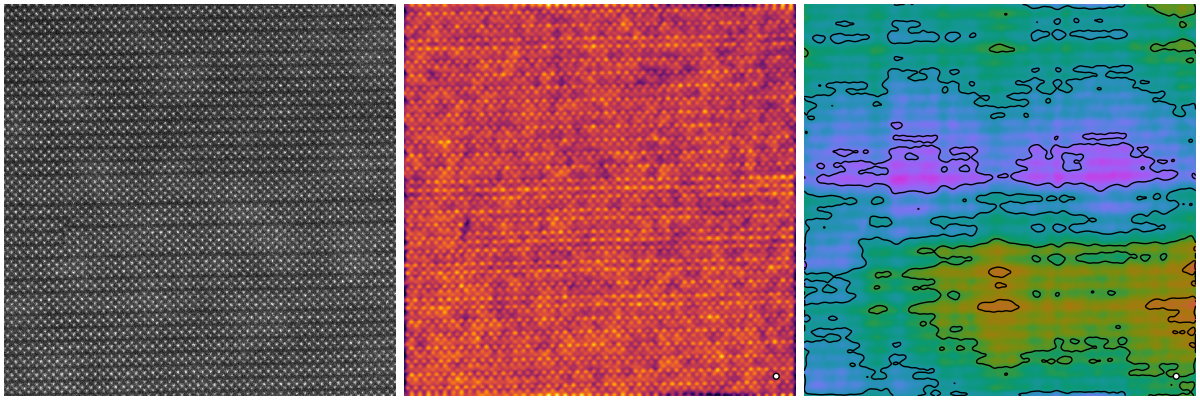

In [11]:
phase = kemstem.fourier.phaselock(filtered_im,peaks_ref[peak_index,:],sigma=25) # different from the sigma above 
# this sigma is a parameter of the lock in analysis and should generally be larger than the sigma used for Fourier filtering
# but should not need to be changed here

fig,ax = plt.subplots(1,3,constrained_layout=True,figsize=(12,4))

ax[0].matshow(image,cmap='gray')
ax[0].axis('off')
ax[1].matshow(np.abs(filtered_im),cmap='inferno')
ax[1].axis('off')
kemstem.util.plot_phase(phase,ax=ax[2])
ax[2].axis('off')

kemstem.util.coarsening_marker(ax[1],kemstem.fourier.coarsening_length(image.shape[0],sigma),edgecolor='k',facecolor='w')
kemstem.util.coarsening_marker(ax[2],kemstem.fourier.coarsening_length(image.shape[0],sigma),edgecolor='k',facecolor='w',zorder=2)

<IPython.core.display.Javascript object>


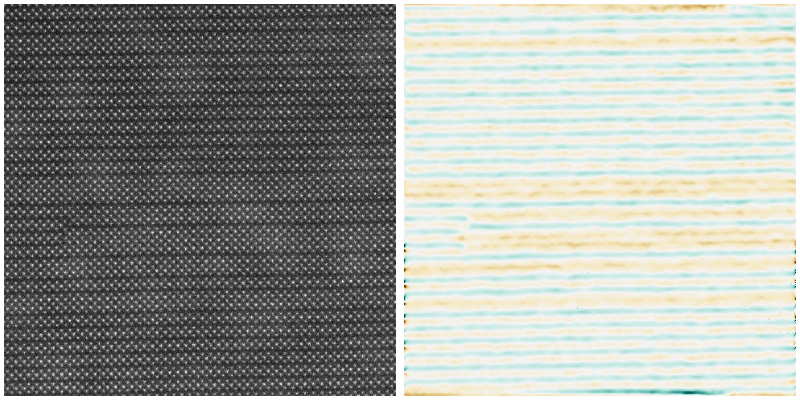

(-0.5, 1023.5, 1023.5, -0.5)

In [12]:
# strain
sv = .3

ref_x = peaks_ref[peak_index,1]-image.shape[0]/2. 
ref_y = peaks_ref[peak_index,0]-image.shape[0]/2. 
eps_par, eps_trans = kemstem.fourier.phase_to_strain(phase, ref_x, ref_y, mask_threshold=1.)
fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(8,4),sharex=True,sharey=True)
ax[0].matshow(image,cmap='gray')
ax[0].axis('off')
ax[1].matshow(eps_par,cmap='BrBG',vmin=-sv,vmax=sv)
ax[1].axis('off')

In [13]:
##parameters for RP mapping

In [13]:
angle = np.arctan(((image.shape[0]/2)-peaks_ref[0][1])/((image.shape[0]/2)-peaks_ref[0][0])) # Defines angle of sample
px_scale = np.sqrt((peaks_ref[0][1]-image.shape[0]/2)**2+(peaks_ref[0][0]-image.shape[0]/2)**2)/(2*image.shape[0]) # units uc/px

<IPython.core.display.Javascript object>


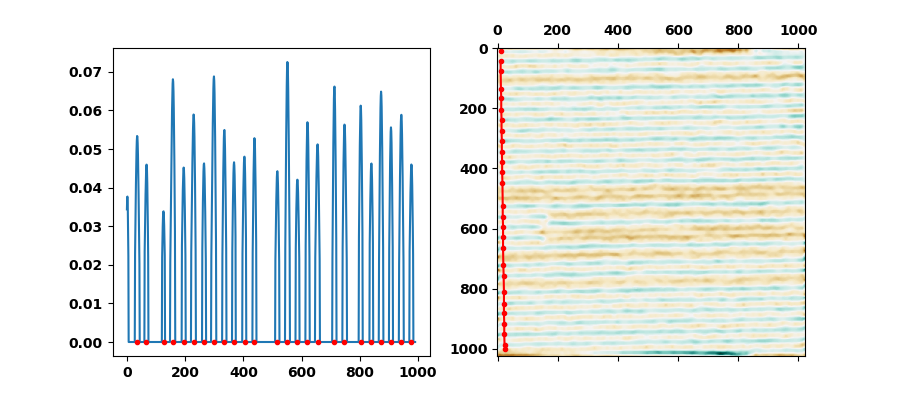

In [14]:
## for checking

x0 = 10
x1 = eps_par.shape[0] - 15
y0= 10
y1 = eps_par.shape[0] - 25

_=kemstem.extensions.ruddlesden_popper.find_RP(eps_par,angle, x0,x1,y0,y1,threshold=0.02, width_peak= 1/(4*px_scale),linewidth = int(1/(px_scale)), distance = 1/px_scale, vis=True)

In [15]:
spacing = 1 
scale = int(spacing/px_scale) 
xrange = np.arange(x0,x1,scale)

RP=[]
for i in xrange:
    xyp = kemstem.extensions.ruddlesden_popper.find_RP(eps_par,angle,i,x1,y0,y1,threshold=0.02, width_peak= 1/(4*px_scale),linewidth = int(1/(px_scale)), distance = 1/px_scale,vis=False)
    RP.append(np.array(xyp))

<IPython.core.display.Javascript object>


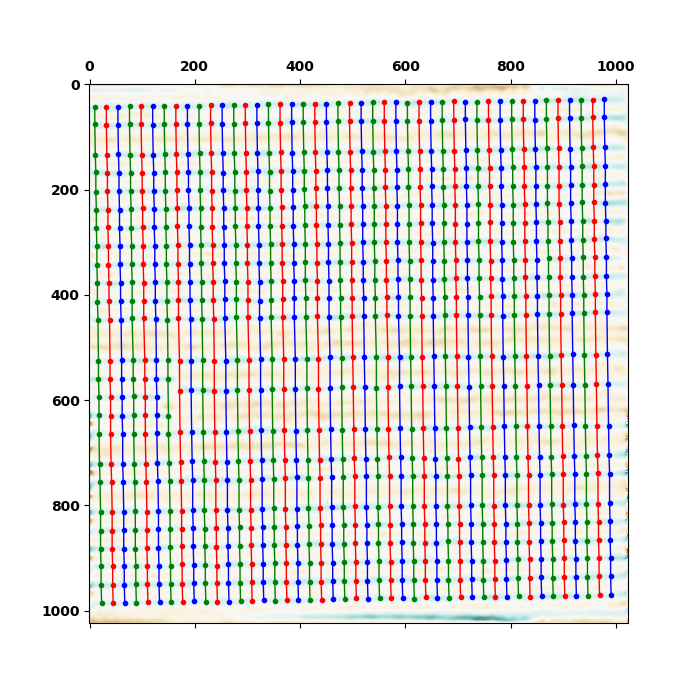

In [16]:
color = ['go-','ro-','bo-']
fig, ax =plt.subplots(1, figsize=(7,7), sharex=True, sharey=True)
c_im0 = ax.matshow(eps_par, vmin=-0.25, vmax=0.25, cmap='BrBG', alpha = 0.6)
for i in range(len(RP)-1):                
    ax.plot(RP[i][:,1], RP[i][:,0], color[np.mod(i,3)] ,linewidth = 1, markersize = 3)

In [17]:
UC_dist,bond_coordinates = kemstem.extensions.ruddlesden_popper.measure_distances(RP,px_scale)

<IPython.core.display.Javascript object>


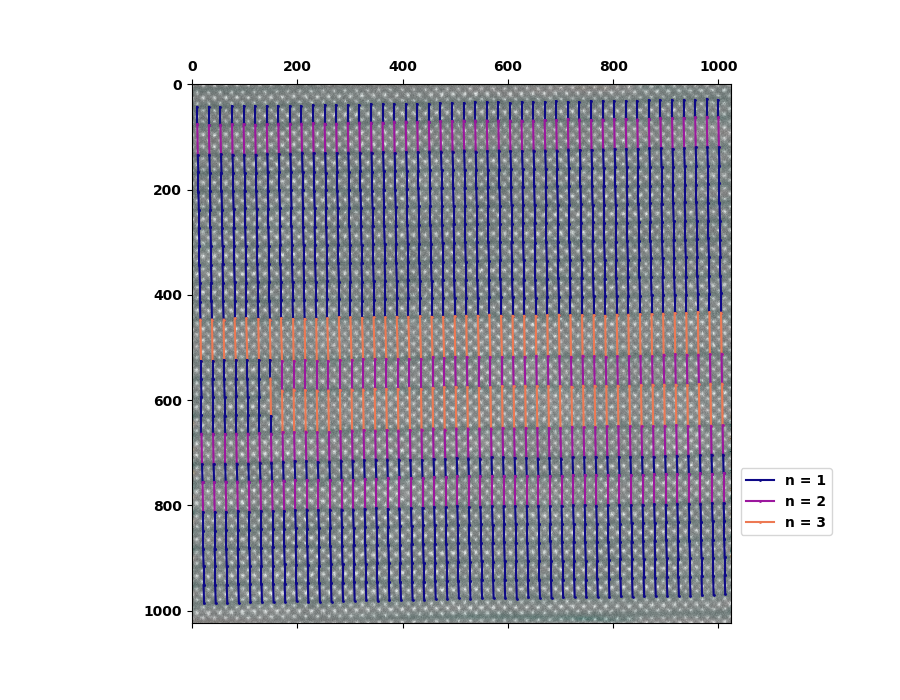

In [18]:
fig, ax =plt.subplots(1, figsize=(9,7), sharex=True, sharey=True)
colors= kemstem.extensions.ruddlesden_popper.vis_bond(ax,image,eps_par,UC_dist,bond_coordinates,cmap='plasma')

<IPython.core.display.Javascript object>


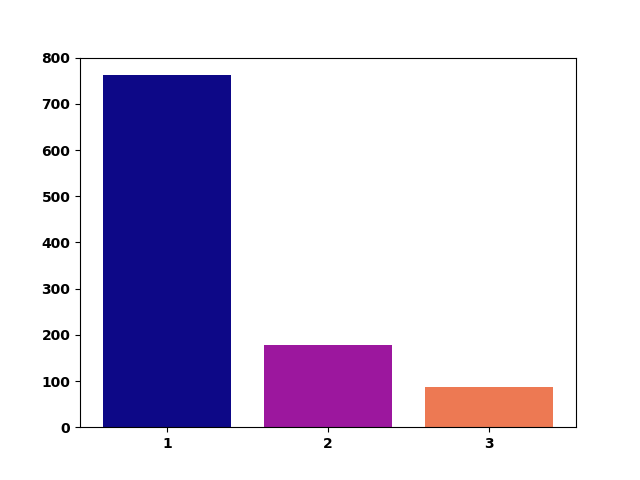

[1 2 3]
[762 177  86]


In [19]:
fig,ax = plt.subplots()
kemstem.extensions.ruddlesden_popper.vis_hist(ax,UC_dist,colors)

In [ ]:
## can also use the inbuilt plot_scalar_bonds to plot the code
fig, ax =plt.subplots(1, figsize=(9,7), sharex=True, sharey=True)
c_im00=ax.matshow(image, cmap='gray')
c_im0 = ax.matshow(eps_par, cmap='BrBG',alpha=0.4)
kemstem.util.viz.plot_scalar_bonds(ax,UC_dist,np.column_stack([np.array(bond_coordinates)[:,1,0],np.array(bond_coordinates)[:,0,0]]),np.column_stack([np.array(bond_coordinates)[:,1,1],np.array(bond_coordinates)[:,0,1]]))